# Lottery Ticket Hypothesis: _Conv-2_ CNN for CIFAR10

Implementation of the hypothesis using 2 convolutional layers having filer size of 3 x 3 followed by a max pooling layer, followed by two dense layers having 256 neurons in each of them, follwed by 10 output neurons

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

/home/arjun/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/arjun/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/arjun/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/arjun/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/arjun/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expe

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare MNIST dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0002)

In [15]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [16]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  83400


In [17]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [18]:
l = tf.keras.layers

In [19]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-2 architecture-
    64, 64, pool  -- convolutions
    256, 256, 10  -- fully connected layers
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        ),
        **pruning_params_conv)
    )
        
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 10, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0002),
        metrics=['accuracy']
    )
    
    
    return pruned_model
    


In [20]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [22]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [23]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [24]:
# Save random weights-
orig_model.save_weights("Conv_2_CIFAR_Ramdom_Weights.h5", overwrite=True)

In [25]:
# Save random weights-
orig_model.save_weights("Conv_2_CIFAR_Winning_Ticket.h5", overwrite=True)

In [26]:
# Get CNN summary-
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 32, 32, 64)        3522      
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 32, 32, 64)        73794     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 16, 16, 64)        1         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 256)               8388866   
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 256)               131330    
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 10)                5

### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic, where the fully-connected (fc) layers are pruned at the rate of 20% per iterative
pruning round and the convolutional (conv) layers are pruned at the rate of 10% per iterative pruning round.

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [27]:
# number of convolutional parameters-
conv1 = 1792
conv2 = 36928

# number of fully-connected dense parameters-
dense1 = 4194560
dense2 = 65792
op_layer = 2570


# total number of parameters-
total_params = conv1 + conv2 + dense1 + dense2 + op_layer

print("\nTotal number of trainable parameters = {0}\n".format(total_params))


Total number of trainable parameters = 4301642



In [28]:
# maximum pruning performed is till 0.5% of all parameters-
max_pruned_params = 0.005 * total_params

In [65]:
loc_tot_params = total_params
loc_conv1 = conv1
loc_conv2 = conv2
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer

# variable to count number of pruning rounds-
n = 0

In [66]:
# Lists to hold percentage of weights pruned in each round for all layers in CNN-
conv1_pruning = []
conv2_pruning = []
dense1_pruning = []
dense2_pruning = []
op_layer_pruning = []


In [67]:
while loc_tot_params >= max_pruned_params:
    loc_conv1 *= 0.9    # 10% weights are pruned
    loc_conv2 *= 0.9    # 10% weights are pruned
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.8 # 20% weights are pruned
    
    conv1_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
    conv2_pruning.append(((conv2 - loc_conv2) / conv2) * 100)
    dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_conv1 + loc_conv2 + loc_dense1 + loc_dense2 + loc_op_layer

    n += 1

    
    print("\nConv1 = {0:.3f}, Conv2 = {1:.3f}".format(loc_conv1, loc_conv2))
    print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
        loc_dense1, loc_dense2, loc_op_layer))
    print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))
    


Conv1 = 1612.800, Conv2 = 33235.200
Dense1 = 3355648.000, Dense2 = 52633.600 & O/p layer = 2056.000
Total number of parameters = 3445185.600


Conv1 = 1451.520, Conv2 = 29911.680
Dense1 = 2684518.400, Dense2 = 42106.880 & O/p layer = 1644.800
Total number of parameters = 2759633.280


Conv1 = 1306.368, Conv2 = 26920.512
Dense1 = 2147614.720, Dense2 = 33685.504 & O/p layer = 1315.840
Total number of parameters = 2210842.944


Conv1 = 1175.731, Conv2 = 24228.461
Dense1 = 1718091.776, Dense2 = 26948.403 & O/p layer = 1052.672
Total number of parameters = 1771497.043


Conv1 = 1058.158, Conv2 = 21805.615
Dense1 = 1374473.421, Dense2 = 21558.723 & O/p layer = 842.138
Total number of parameters = 1419738.054


Conv1 = 952.342, Conv2 = 19625.053
Dense1 = 1099578.737, Dense2 = 17246.978 & O/p layer = 673.710
Total number of parameters = 1138076.820


Conv1 = 857.108, Conv2 = 17662.548
Dense1 = 879662.989, Dense2 = 13797.582 & O/p layer = 538.968
Total number of parameters = 912519.196


Conv1

In [68]:
print("\nnumber of pruning rounds = {0}\n\n".format(n))


number of pruning rounds = 25




In [69]:
num_pruning_rounds = n

In [70]:
# Convert from list to np.array-
conv1_pruning = np.array(conv1_pruning)
conv2_pruning = np.array(conv2_pruning)
dense1_pruning = np.array(dense1_pruning)
dense2_pruning = np.array(dense2_pruning)
op_layer_pruning = np.array(op_layer_pruning)

In [71]:
# Round off numpy arrays to 3 decimal digits-
conv1_pruning = np.round(conv1_pruning, decimals=3)
conv2_pruning = np.round(conv2_pruning, decimals=3)
dense1_pruning = np.round(dense1_pruning, decimals=3)
dense2_pruning = np.round(dense2_pruning, decimals=3)
op_layer_pruning = np.round(op_layer_pruning, decimals=3)

In [ ]:
# Sanity check-
for i in range(6):
    print("\nconv1 = {0:.2f}, conv2 = {1:.2f}".format(conv1_pruning[i], conv2_pruning[i]))
    print("dense1 = {0:.2f}, dense2 = {1:.2f} & op = {2:.2f}\n".format(dense1_pruning[i], dense2_pruning[i], op_layer_pruning[i]))

In [72]:
conv1_pruning = conv1_pruning / 100
conv2_pruning = conv2_pruning / 100
dense1_pruning = dense1_pruning / 100
dense2_pruning = dense2_pruning / 100
op_layer_pruning = op_layer_pruning / 100


In [74]:
dense1_pruning

array([0.2    , 0.36   , 0.488  , 0.5904 , 0.67232, 0.73786, 0.79028,
       0.83223, 0.86578, 0.89263, 0.9141 , 0.93128, 0.94502, 0.95602,
       0.96482, 0.97185, 0.97748, 0.98199, 0.98559, 0.98847, 0.99078,
       0.99262, 0.9941 , 0.99528, 0.99622])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [75]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

In [76]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [77]:
# Assign all masks to one-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [78]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

1728
64
36864
64
4194304
256
65536
256
2560
10

Total number of trainable parameters = 4301642



In [79]:
print("\nnumber of pruning rounds for Conv-2 CNN = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for Conv-2 CNN = 25 and number of epochs = 100



### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [80]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)

    history_main[x + 1] = history


In [81]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [82]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [83]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [84]:
best_val_loss = 100
loc_patience = 0

In [85]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    model_gt = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load winning ticket (from above)-
    model_gt.load_weights("Conv_2_CIFAR_Winning_Ticket.h5")
    
    # Strip model of pruning parameters-
    model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        '''
        # Initialize 'grad_mask_mul' list-
        grad_mask_mul = []
    
        # Initialize all values to one-
        for wts in mask_model_stripped.trainable_weights:
            grad_mask_mul.append(wts.assign(tf.ones_like(input = wts,dtype = tf.float32)))
    
        # Convert from Python list to tf.Tensor-
        grad_mask_mul = tf.convert_to_tensor(grad_mask_mul, dtype=tf.float32)
    
        print("type(grad_mask_mul): {0}".format(type(grad_mask_mul)))
        '''
    
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model, optimizer, x, y, grad_mask_mul)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(x_t, y_t)
            test_step(model_gt_stripped, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    model_gt.save_weights("Conv_2_CIFAR_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Specify the parameters to be used for layer-wise pruning, Conv layer-
    pruning_params_conv = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=conv1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }

    
    # Specify the parameters to be used for layer-wise pruning, Fully-Connected layer pruning-
    pruning_params_fc = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=dense1_pruning[i - 1], begin_step = 1000,
            end_step = end_step, frequency=100
        )
    }
    
    
    # Instantiate a Nueal Network model to be pruned using parameters from above-
    pruned_model = pruned_nn(pruning_params_conv, pruning_params_fc)
    
    # Load weights from original trained and unpruned model-
    pruned_model.load_weights("Conv_2_CIFAR_Trained_Weights.h5")
    
    # Train pruned NN-
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    
    # Strip the pruning wrappers from pruned model-
    pruned_model_stripped = sparsity.strip_pruning(pruned_model)
    
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    '''
    # Sanity-check: confirm that the weights are actually pruned away from the network-
    print("\nRound = {0}, % of weights pruned away = {1:.2f}%\n".format( \
                                                i, (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))
    '''
    
    # Save weights of PRUNED and Trained model BEFORE stripping-
    pruned_model.save_weights("Conv_2_CIFAR_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    mask_model.load_weights("Conv_2_CIFAR_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    
    
    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    winning_ticket_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    
    # Load weights of PRUNED model-
    winning_ticket_model.load_weights("Conv_2_CIFAR_Pruned_Weights.h5")
    
    # Strip the model of its pruning parameters-
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Save the weights (with pruning parameters) extracted to a file-
    winning_ticket_model.save_weights("Conv_2_CIFAR_Winning_Ticket.h5", overwrite=True)
    
    
    
    




Iterative pruning round: 1


Epoch 1, Loss: 1.3794, Accuracy: 49.9120, Test Loss: 1.1332, Test Accuracy: 59.490002
Total number of trainable parameters = 4301640

Epoch 2, Loss: 1.0210, Accuracy: 63.7560, Test Loss: 0.9885, Test Accuracy: 65.120003
Total number of trainable parameters = 4301640

Epoch 3, Loss: 0.8740, Accuracy: 69.4600, Test Loss: 0.9806, Test Accuracy: 65.230003
Total number of trainable parameters = 4301641

Epoch 4, Loss: 0.7687, Accuracy: 72.9780, Test Loss: 0.9095, Test Accuracy: 68.159996
Total number of trainable parameters = 4301642

Epoch 5, Loss: 0.6794, Accuracy: 76.5160, Test Loss: 0.9020, Test Accuracy: 68.839996
Total number of trainable parameters = 4301642

Epoch 6, Loss: 0.5902, Accuracy: 79.5260, Test Loss: 0.8926, Test Accuracy: 69.950005
Total number of trainable parameters = 4301642

Epoch 7, Loss: 0.5009, Accuracy: 82.8980, Test Loss: 0.9208, Test Accuracy: 70.520004
Total number of trainable parameters = 4301642

Epoch 8, Loss: 0.4155, Accurac

In [86]:
print("\nIterative-pruning for Lottery Ticket Hypothesis is now complete.\n")


Iterative-pruning for Lottery Ticket Hypothesis is now complete.



In [87]:
import os
import pickle

In [88]:
os.getcwd()

'/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources'

In [89]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/history_main.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [1]:
history_main_info = {}

# number of epochs per iterative pruning round BEFORE early stopping kicked in-
num_epochs_early_stopping = [9, 9, 10, 7, 7, 7, 7, 7, 7, 8, 9, 8, 9, 12, 13, 18, 20, 23, 29, 24, 26, 32, 37, 33, 35]

In [2]:
# total number of parameters remaing AFTER (or at the end of) each
# iterative pruning round-
total_num_params_end_pruning_round = [3445303, 2759830, 2211106, 1771804,
        1420073, 1138434, 912927, 732245, 587577, 471618, 378735, 304277,
        244603, 196739, 158379, 127572, 102804, 82899, 66949, 54131,
        43800, 35512, 28808, 23426, 19090]

In [4]:
# number of parameters before any pruning-
orig_sum_params = 4301642

In [5]:
# compute % of weights pruned at the end of each iterative pruning round-
percentage_wts_pruned = []

for pruned_wts in total_num_params_end_pruning_round:
    percentage_wts_pruned.append((orig_sum_params - pruned_wts) / orig_sum_params * 100)


In [17]:
percentage_wts_pruned[0]

19.90725867006134

In [14]:
for wts in percentage_wts_pruned:
    print("{0:.4f}% of weights are pruned".format(wts))

19.9073% of weights are pruned
35.8424% of weights are pruned
48.5986% of weights are pruned
58.8110% of weights are pruned
66.9877% of weights are pruned
73.5349% of weights are pruned
78.7772% of weights are pruned
82.9775% of weights are pruned
86.3406% of weights are pruned
89.0363% of weights are pruned
91.1956% of weights are pruned
92.9265% of weights are pruned
94.3137% of weights are pruned
95.4264% of weights are pruned
96.3182% of weights are pruned
97.0343% of weights are pruned
97.6101% of weights are pruned
98.0729% of weights are pruned
98.4436% of weights are pruned
98.7416% of weights are pruned
98.9818% of weights are pruned
99.1745% of weights are pruned
99.3303% of weights are pruned
99.4554% of weights are pruned
99.5562% of weights are pruned


In [10]:
import pickle

In [11]:
# Load pickled Python 3 dict containing training heuristics-
with open("/home/arjun/Desktop/Codes/Lottery_Hypothesis-Resources/Latest_Works/history_main.pkl", "rb") as f:
    history_main = pickle.load(f)


In [15]:
# Python 3 dict for training and testing accuracy visualization-
plot_accuracy = {}
plot_test_accuracy = {}


# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}


In [16]:
# Populate 'plot_test_accuracy' Python 3 dict-
i = 0
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    # print("training accuracy = {0:.4f}%".format(history_main[k]['accuracy'][epoch_length - 1]))
    plot_test_accuracy[percentage_wts_pruned[i]] = history_main[k]['val_accuracy'][epoch_length - 1]
    
    i = i + 1


# Populate 'plot_accuracy' Python 3 dict-
i = 0
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[percentage_wts_pruned[i]] = history_main[k]['accuracy'][epoch_length - 1]
    
    i = i + 1


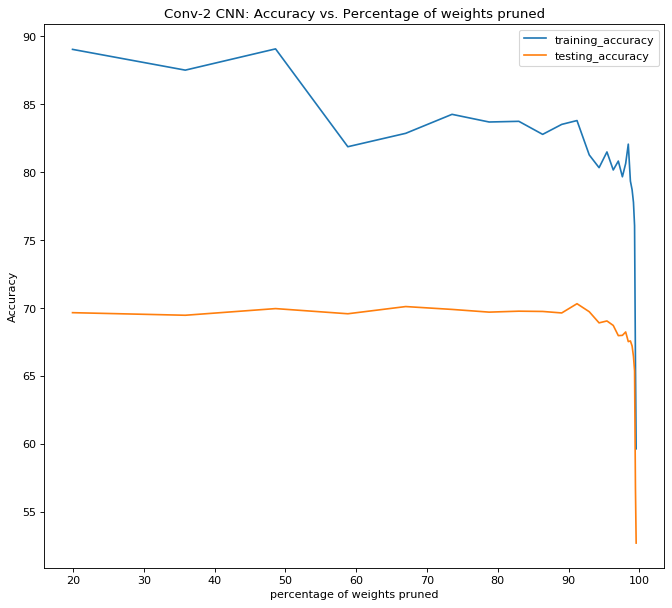

In [23]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("Conv-2 CNN: Accuracy vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()



In [20]:
# Populate 'plot_loss' Python 3 dict-
i = 0
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_loss[percentage_wts_pruned[i]] = history_main[k]['loss'][epoch_length - 1]
    
    i = i + 1


# Populate 'plot_test_loss' Python 3 dict-
i = 0
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_loss[percentage_wts_pruned[i]] = history_main[k]['val_loss'][epoch_length - 1]
    
    i = i + 1


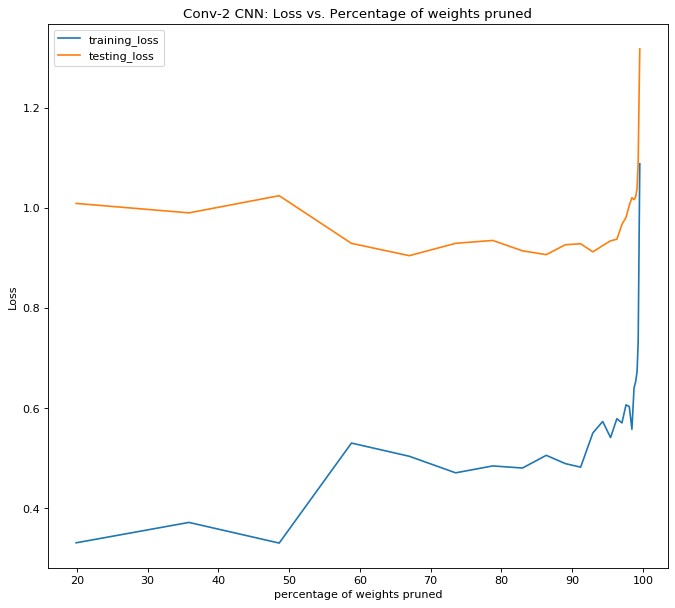

In [24]:
# Visualization of training and testing loss VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("Conv-2 CNN: Loss vs. Percentage of weights pruned")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()



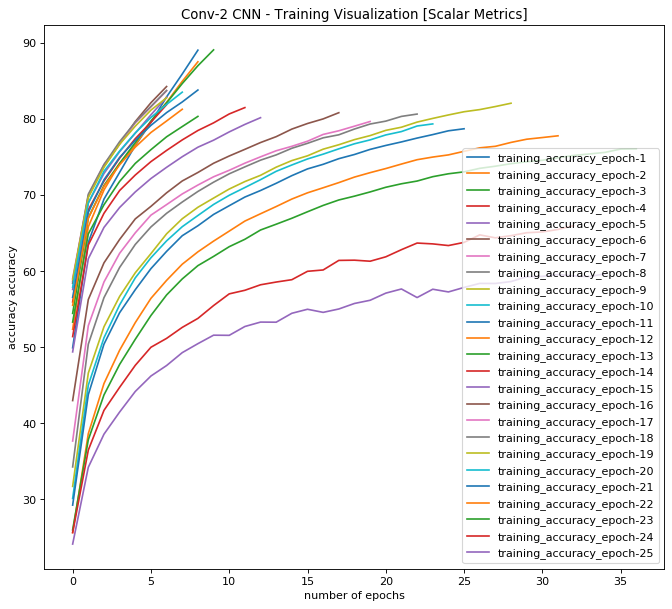

In [103]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for k in history_main.keys():
    plt.plot(history_main[k]['accuracy'], label = 'training_accuracy_epoch-{0}'.format(k))
    # plt.plot(history_main[k]['val_accuracy'], label = 'testing_accuracy_epoch-{0}'.format(k))

plt.title("Conv-2 CNN - Training Visualization [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("accuracy accuracy")
plt.legend(loc = 'best')
plt.show()

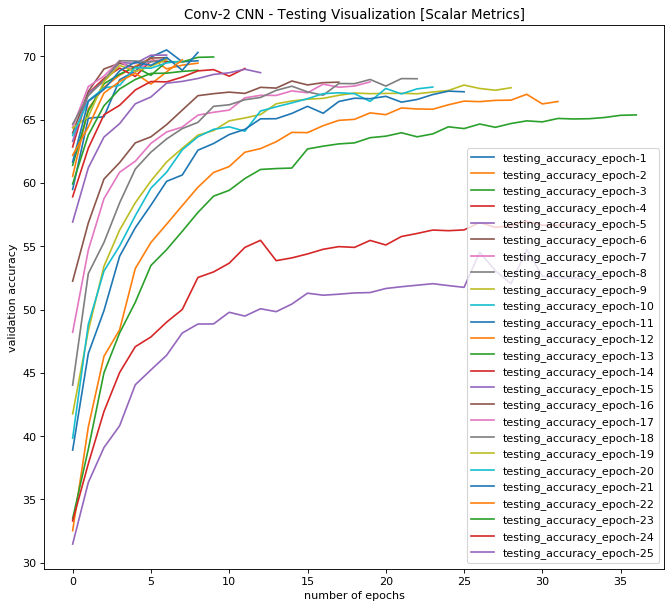

In [104]:

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

for k in history_main.keys():
    # plt.plot(history_main[k]['accuracy'], label = 'training_accuracy_epoch-{0}'.format(k))
    plt.plot(history_main[k]['val_accuracy'], label = 'testing_accuracy_epoch-{0}'.format(k))

plt.title("Conv-2 CNN - Testing Visualization [Scalar Metrics]")
plt.xlabel("number of epochs")
plt.ylabel("validation accuracy")
plt.legend(loc = 'best')
plt.show()